# COMP90072 Project

## Imports and Initialisations

In [7]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import sow

np.random.seed(90072)


## Basic BTW Model

In this section, we explore the basic BTW model to verify the correctness of 
implementation. 

### Toppling Check

The main aim is to check if toppling proceeded as expected.

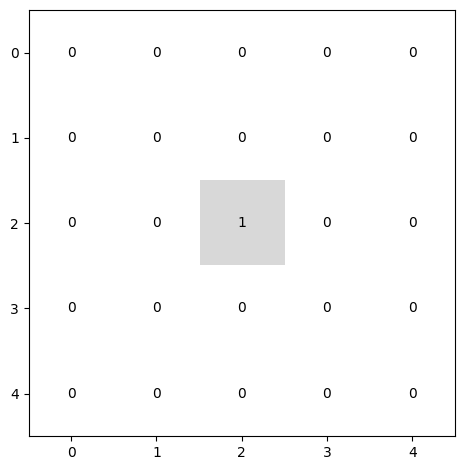

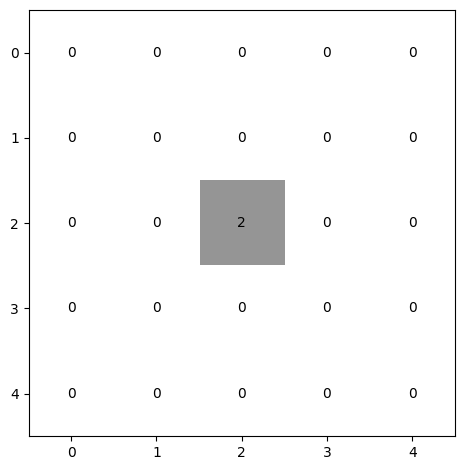

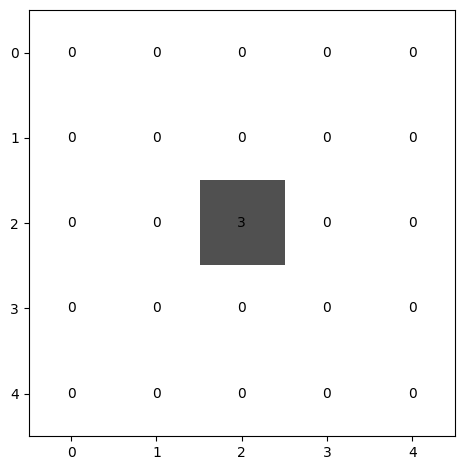

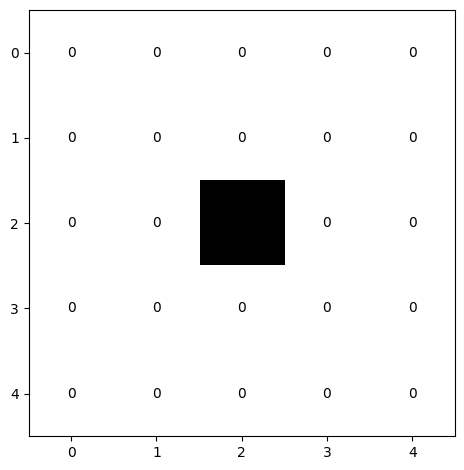

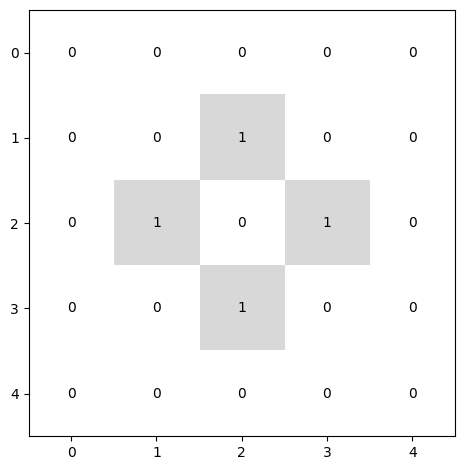

In [3]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(5, 5)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# We drop at sand at the same spot to check the model. Notice that the middle 
# point is floor of half the vertex count, by design.
model.manager = sow.ConstantDropper(graph.vcount() // 2)

# Create a custom grid visualiser 
def grid_visualiser(context: sow.SimulationContext):
    return sow.visualise_grid(
        5, 5, context.model.height, max_height=context.model.topple_limit, 
        xticks="auto", yticks="auto", labels="auto")

# Create the listeners. 
image_maker = sow.ImageMaker(visualiser=grid_visualiser)
video_maker = sow.MovieMaker(max_frame=model.t_lim)

model.add_listener([
    image_maker
])

# Run the simulation.
_ = model.simulate(5)

# View the images.
for x in image_maker.images[:5]:
    x[0].show()


### Correctness-check: Pattern at Scale

In this subsection, we check if the pattern of the model matches the expected 
pattern of BTW models, as well as its algorithmic complexity.


(<Figure size 640x480 with 1 Axes>, <Axes: >)

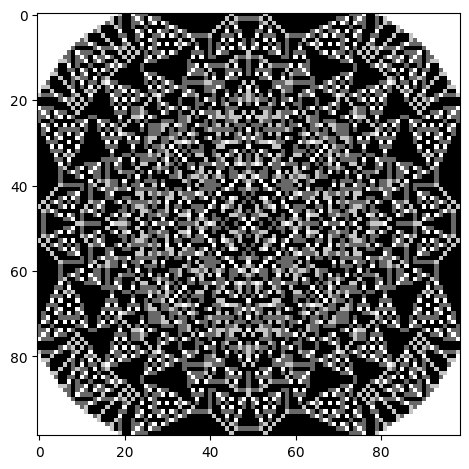

In [5]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(99, 99)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# We drop at sand at the same spot to check the model. Notice that the middle 
# point is floor of half the vertex count, by design.
model.manager = sow.ConstantDropper(graph.vcount() // 2)

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(10_000_000)
model.visualise_grid(99, 99)


### Statistics on BTW

In this subsection, we study the mean height of BTW models.


In [6]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(20, 20)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# Add the mean collector listener.
mean_collector = sow.StatisticsCollector(sow.ContextTransformer.mean_height)
model.add_listener([mean_collector])

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(10_000)


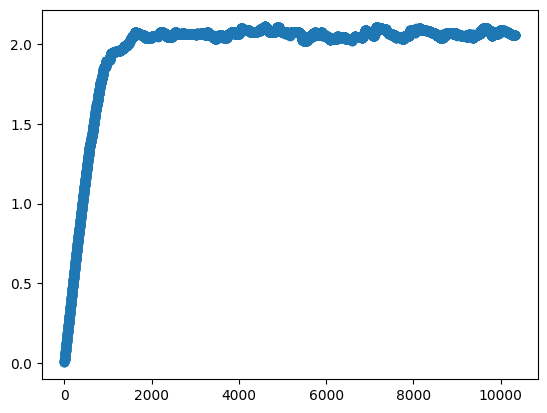

In [7]:
# Plots the result as a graph.
plt.scatter(np.arange(0, len(mean_collector.value_history)), 
            mean_collector.value_history)
plt.show()


### Topple Frequency and Avalanche Properties

Here we study the toppling behaviour of grid BTW and investigate avalanche 
properties of the model.

In [43]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(20, 20)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# Add the mean collector listener.
topple_occurrence_collector = sow.StatisticsCollector(
    sow.ContextTransformer.topple_occurrence)
topple_loss_collector = sow.StatisticsCollector(
    sow.ContextTransformer.topple_loss)
drop_location_collector = sow.StatisticsCollector(
    sow.ContextTransformer.drop_location
)
model.add_listener([
    topple_occurrence_collector, topple_loss_collector, drop_location_collector
])

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(10_000_000)


In [9]:
# This is the proportion of time attributed to toppling.
np.mean(topple_occurrence_collector.value_history)

0.9435727492447734

#### Avalanche Duration

This is the distribution of avalanche duration, i.e., number of topples per 
avalanche. 

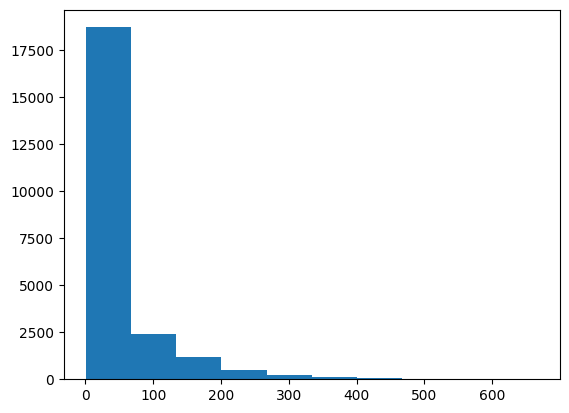

In [3]:
topple_occurrence = [x for x in topple_occurrence_collector.value_history 
                     if x != np.nan]
topple_loss = [x for x in topple_loss_collector.value_history if x != np.nan]
avalanche_duration, avalanche_loss = (
    sow.avalanche_statistics(topple_occurrence, topple_loss))
avalanche_count = len(avalanche_duration)

plt.hist(avalanche_duration)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     8090.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          6.63e-292
Time:                        14:19:52   Log-Likelihood:                -3642.8
No. Observations:                 457   AIC:                             7290.
Df Residuals:                     455   BIC:                             7298.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5877.1157    173.358     33.902      0.0

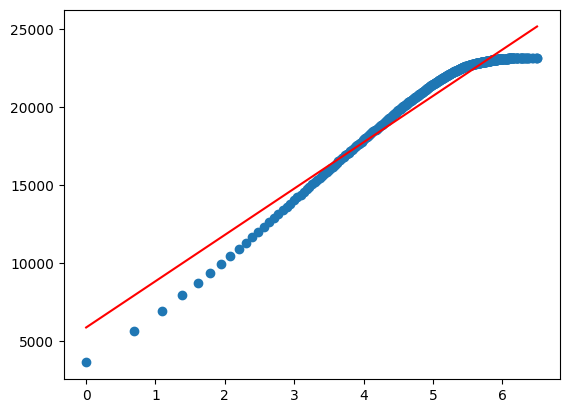

In [40]:
# Fitting the distribution. 
# For robustness, we fit the empirical distribution function instead.
pmf = sorted([(x, y) for x, y in Counter(avalanche_duration).items()])
edf_x, pmf_y = zip(*pmf)
edf_y = np.cumsum(pmf_y)

stats_model = sm.OLS(edf_y, sm.add_constant(np.log(edf_x)))
result = stats_model.fit()
print(result.summary())

plt.scatter(np.log(edf_x), edf_y)
plt.plot(np.log(edf_x), result.fittedvalues, color='r', linestyle='-', 
         linewidth=1.5)
plt.show()


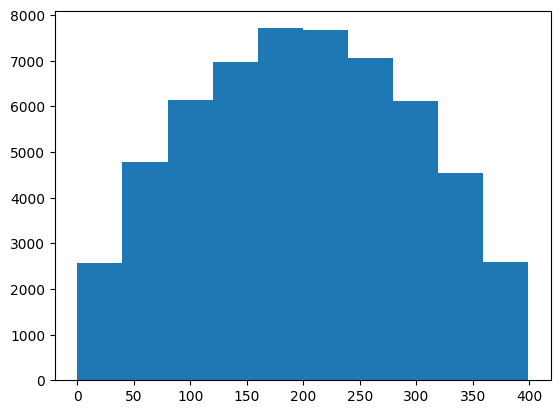

In [50]:
drop_location = drop_location_collector.value_history

plt.hist([x for x, y in zip(drop_location, topple_occurrence) if not y])
plt.show()

#### Avalanche Loss Distribution

This is the number of sand lost per avalanche.

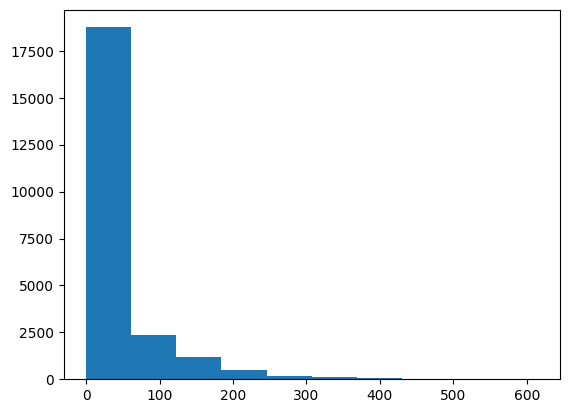

In [4]:
plt.hist(avalanche_loss)
plt.show()

## 

In [ ]:
# This is the toppling height distribution.
topple_occurrence = [x for x in topple_occurrence_collector.value_history 
                     if x != np.nan]
topple_loss = [x for x in topple_loss_collector.value_history if x != np.nan]
avalanche_loss = sow.avalanche_loss(topple_occurrence, topple_loss)
avalanche_count = len(avalanche_loss)

plt.hist(avalanche_loss)
plt.show()

## The Graph Extension of BTW

Now we consider the more general case where we 

In [2]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(20, 20)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# Add the mean collector listener.
topple_freq_collector = sow.StatisticsCollector(
    sow.ContextTransformer.topple_occurrence)
topple_height_collector = sow.StatisticsCollector(
    sow.ContextTransformer.topple_height)
model.add_listener([topple_freq_collector, topple_height_collector])

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(1_000_000)


AttributeError: type object 'ContextTransformer' has no attribute 'topple_height'